In [6]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility

In [ ]:
## Save dynamic model on ramp 21

In [7]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def train(current_weights, X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Scaler initiation
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def trigger(current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
    
    if time_range == (-10,0):
        model.save("models/Ramp21-dynamic.h5")
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Quantify how much each data point is far away from the distribution
    log_test_loss = np.log10(test_loss) - prev_median
    
    #Find the trigger time
    trigger_index = np.argmax(log_test_loss > 3.3)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, log_test_loss, color = "firebrick")
        plt.title("Log reconstruction loss on {}".format(time_range))
        plt.xlabel("Time [s]")
        
        #Trigger time
        plt.vlines(time_test[trigger_index], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left")
        
        
        ### Find trigger times
        peaks, _ = find_peaks(log_test_loss, height=3.3, distance = 5000)
        print("Other trigger time: ", time_test[peaks])
        print("Their log loss values are: ", log_test_loss[peaks])
        
        for i in range(len(peaks)):
            plt.vlines(time_test[peaks[i]], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed")
            
        plt.show()
        
        return list(time_test[peaks])
    
    else:
        return None
    

def simulation_dynamic(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_median = None
    updated_median = None
    
    #Keeping track of scaler after training
    past_scaler = None
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Keeping log of all the trigger time
    trigger_log = []
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        print("-------->")
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, time_range)
        else:
            
            #Set previous distrubution to the newly trained disttribution
            prev_median = updated_median
            current_scaler = new_scaler
            current_weights = new_weights
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, train_time_range)
            trigger_time = trigger(current_weights, X, time_axis, trigger_time_range, prev_median, current_scaler)
            
            if trigger_time is not None:
                print("Triggered at: ", trigger_time)
                trigger_log.extend(trigger_time)
        
        print("<--------")
        
    print("Finished simulation, all the triggered times are: ", trigger_log)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1197500, 12)
Flushing input history
Number of sections: 12
Entering sections:  (-120, -110)
-------->
Entering sections:  (-110, -100)
-------->
Training for section:  (None, -110)


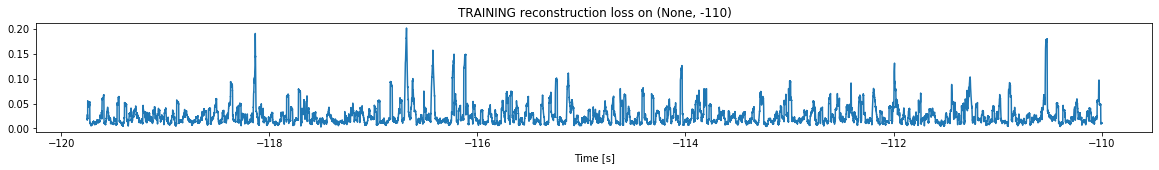

Finished training, median of the log(loss) is:  -1.6963054441179022
<--------
Entering sections:  (-100, -90)
-------->
Training for section:  (-110, -100)


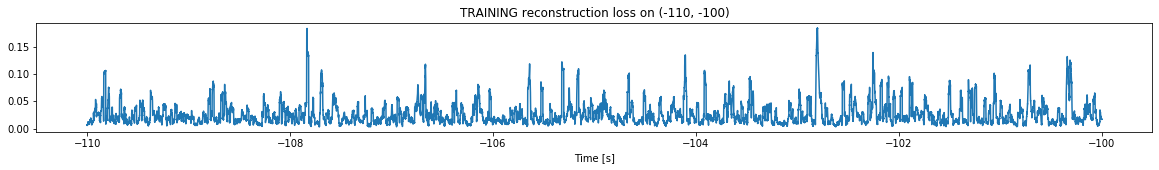

Finished training, median of the log(loss) is:  -1.6857409287761222
Triggering for section:  (-100, -90)
Using this median for triggering: -1.6963054441179022


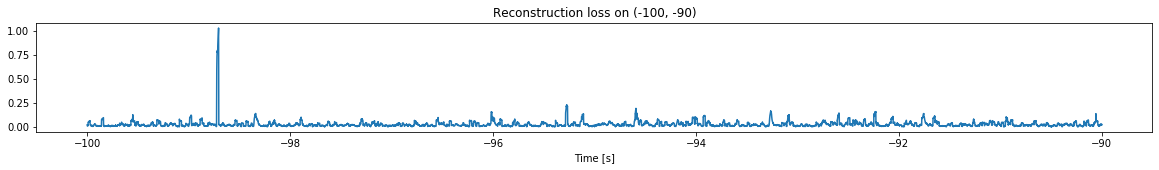

<--------
Entering sections:  (-90, -80)
-------->
Training for section:  (-100, -90)


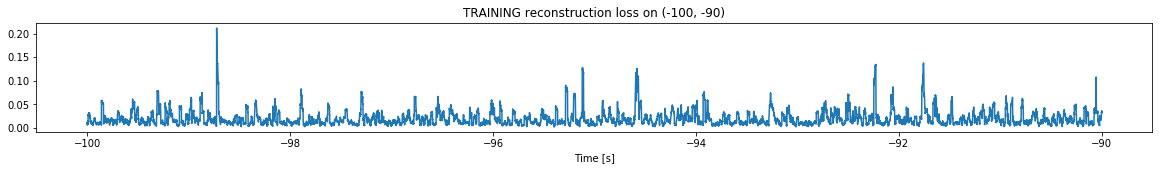

Finished training, median of the log(loss) is:  -1.810742226385756
Triggering for section:  (-90, -80)
Using this median for triggering: -1.6857409287761222


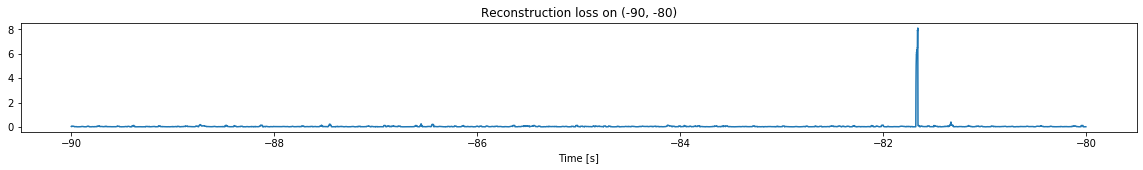

<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


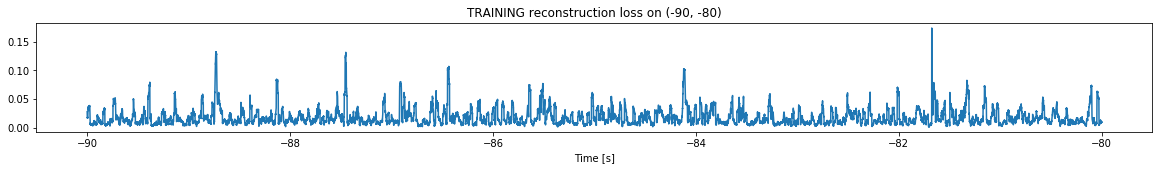

Finished training, median of the log(loss) is:  -1.8482209311957727
Triggering for section:  (-80, -70)
Using this median for triggering: -1.810742226385756


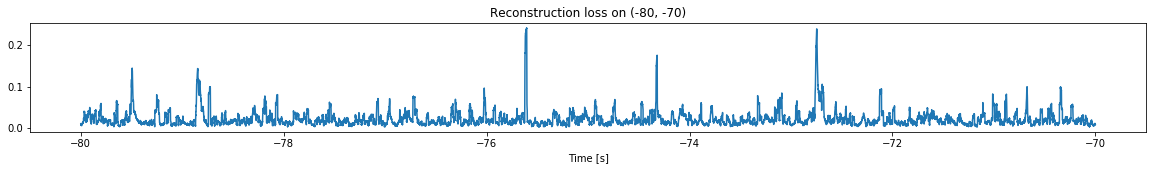

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


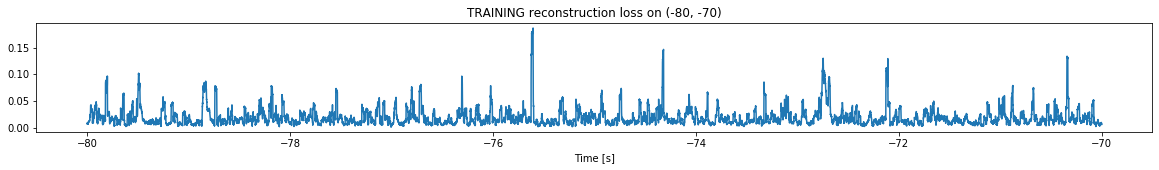

Finished training, median of the log(loss) is:  -1.8155412752556734
Triggering for section:  (-70, -60)
Using this median for triggering: -1.8482209311957727


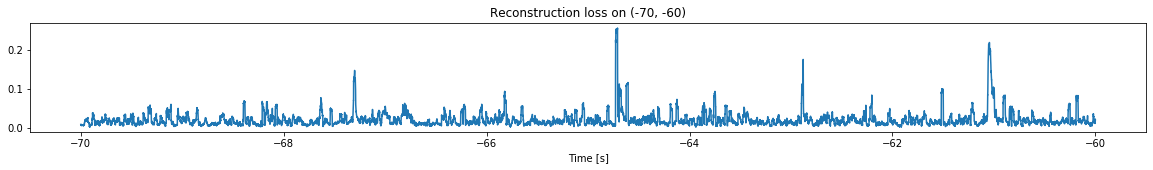

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


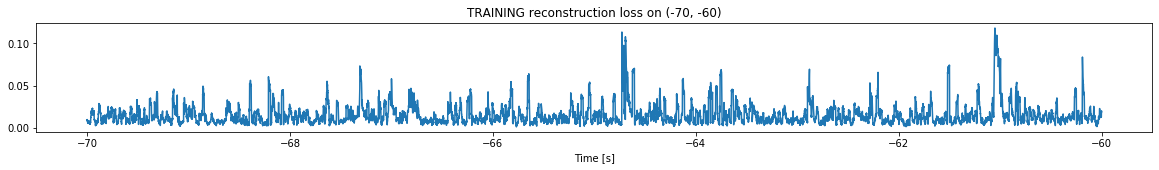

Finished training, median of the log(loss) is:  -1.9102535374282388
Triggering for section:  (-60, -50)
Using this median for triggering: -1.8155412752556734


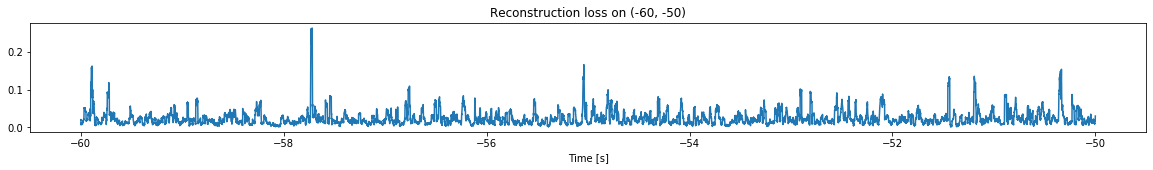

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


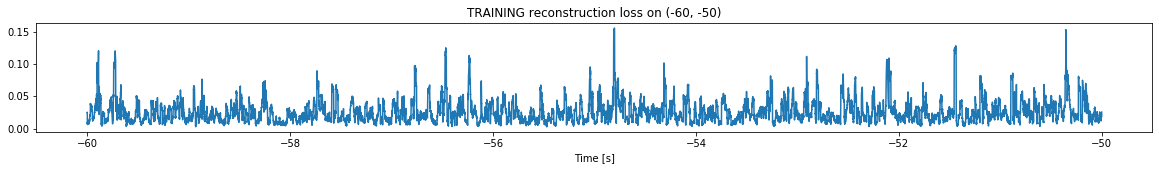

Finished training, median of the log(loss) is:  -1.6619866891780843
Triggering for section:  (-50, -40)
Using this median for triggering: -1.9102535374282388


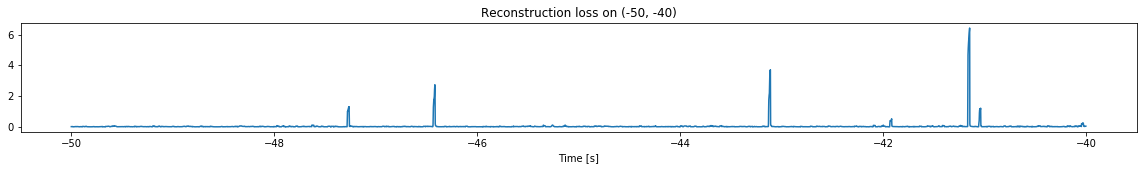

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


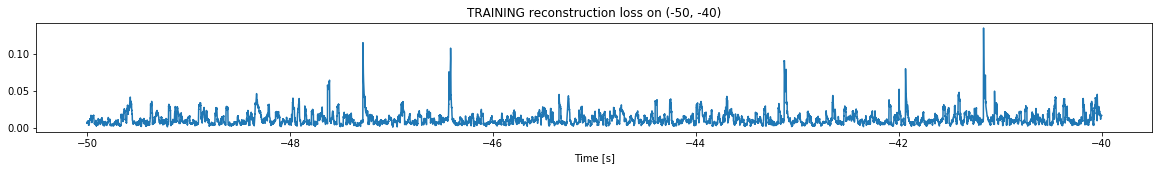

Finished training, median of the log(loss) is:  -2.023012071221542
Triggering for section:  (-40, -30)
Using this median for triggering: -1.6619866891780843


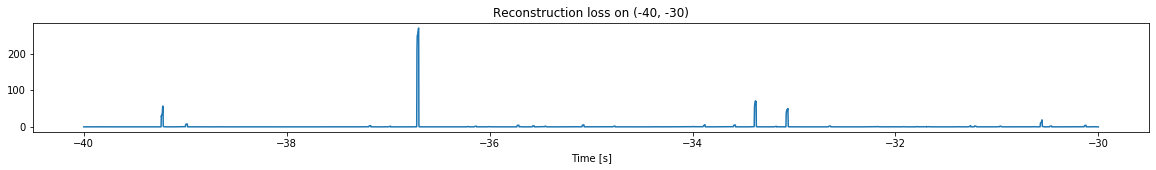

Other trigger time:  [-39.2193   -36.699398 -33.379498]
Their log loss values are:  [3.41263984 4.09302005 3.51418211]


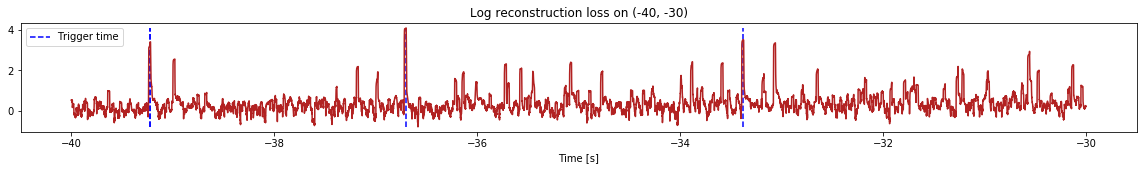

Triggered at:  [-39.2193, -36.699398, -33.379498]
<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


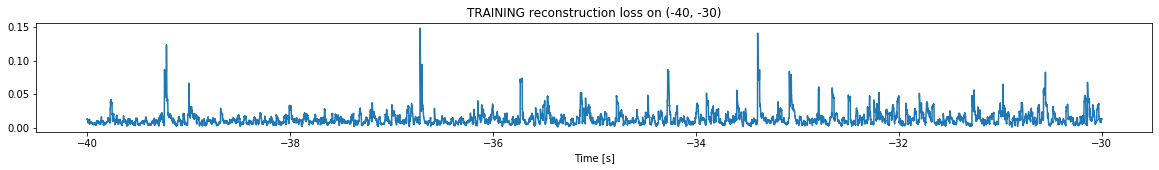

Finished training, median of the log(loss) is:  -1.9799902445643685
Triggering for section:  (-30, -20)
Using this median for triggering: -2.023012071221542


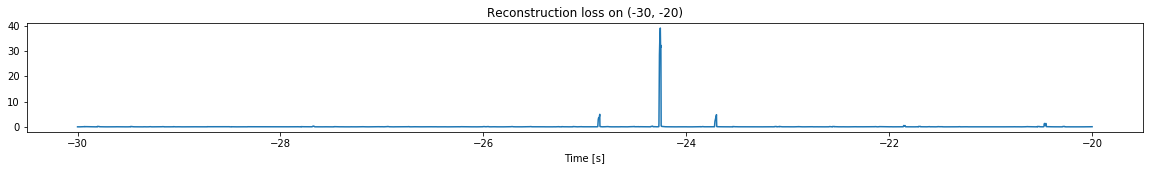

Other trigger time:  [-24.255999]
Their log loss values are:  [3.61448024]


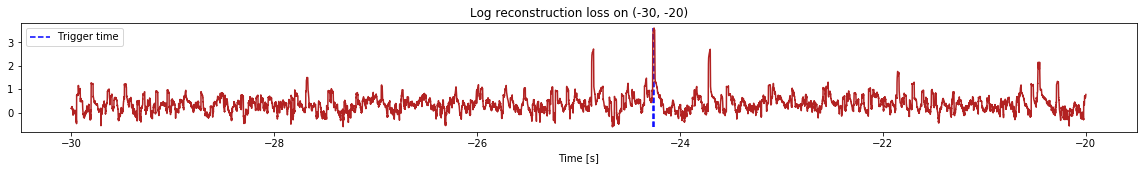

Triggered at:  [-24.255999]
<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


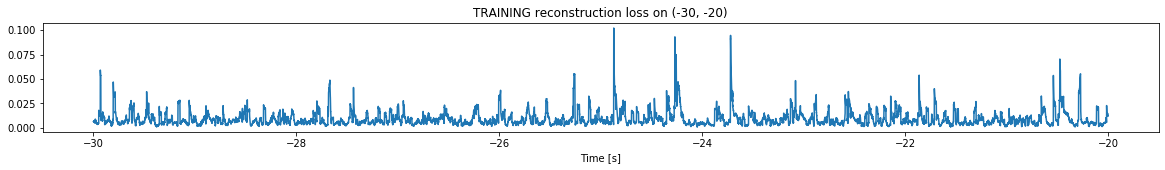

Finished training, median of the log(loss) is:  -2.1490710590013435
Triggering for section:  (-20, -10)
Using this median for triggering: -1.9799902445643685


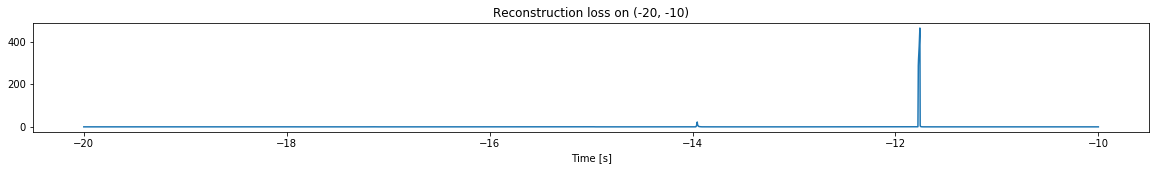

Other trigger time:  [-13.9532995 -11.759    ]
Their log loss values are:  [3.33774561 4.64755781]


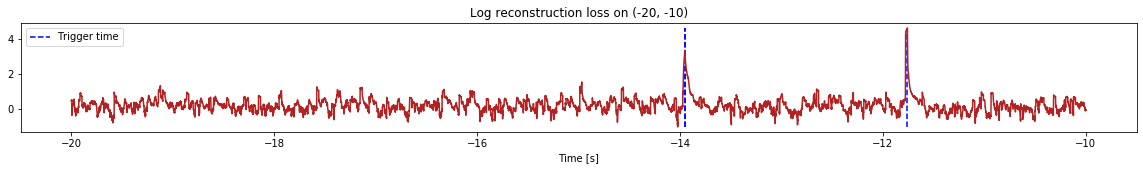

Triggered at:  [-13.9532995, -11.759]
<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


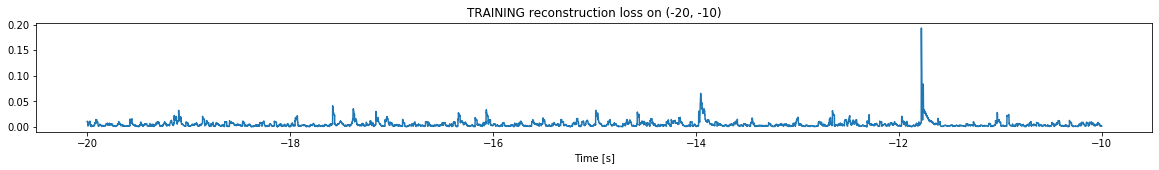

Finished training, median of the log(loss) is:  -2.415998250662041
Triggering for section:  (-10, 0)
Using this median for triggering: -2.1490710590013435


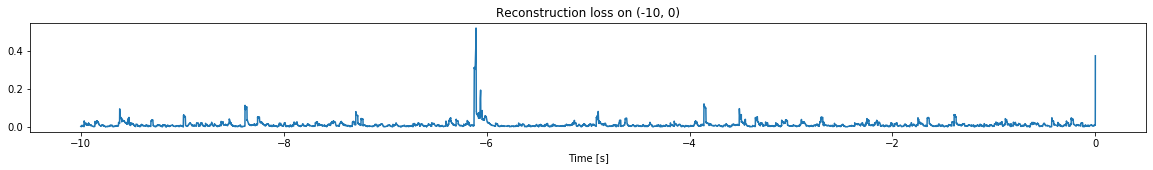

<--------
Finished simulation, all the triggered times are:  [-39.2193, -36.699398, -33.379498, -24.255999, -13.9532995, -11.759]


In [8]:
simulation_dynamic("./data/Ramp21/", 10, (-120,0))

In [9]:
## Save model on static training

In [2]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def train(X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    model.save("models/Ramp21-static.h5")
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def trigger(current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Quantify how much each data point is far away from the distribution
    log_test_loss = np.log10(test_loss) - prev_median
    
    #Find the trigger time
    trigger_index = np.argmax(log_test_loss > 3.3)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, log_test_loss, color = "firebrick")
        plt.title("Log reconstruction loss on {}".format(time_range))
        plt.xlabel("Time [s]")
        
        #Trigger time
        plt.vlines(time_test[trigger_index], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left")
        
        
        ### Find trigger times
        peaks, _ = find_peaks(log_test_loss, height=3.3, distance = 5000)
        print("Other trigger time: ", time_test[peaks])
        print("Their log loss values are: ", log_test_loss[peaks])
        
        for i in range(len(peaks)):
            plt.vlines(time_test[peaks[i]], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed")
            
        plt.show()
        
        return list(time_test[peaks])
    
    else:
        return None
    

def simulation_static(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #Calculate the training and the triggering time. 
    training_range = (time_range[0], time_range[0] + section_size)
    trigger_range = ( time_range[0] + section_size, time_range[1])
        
    #Train and then trigger
    train_weights, train_median, train_scaler = train(X, time_axis, training_range)
    trigger_time = trigger(train_weights, X, time_axis, trigger_range, train_median, train_scaler)
            
    if trigger_time is not None:
        print("Triggered at: ", trigger_time)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1197500, 12)
Flushing input history
Training for section:  (-120, -110)


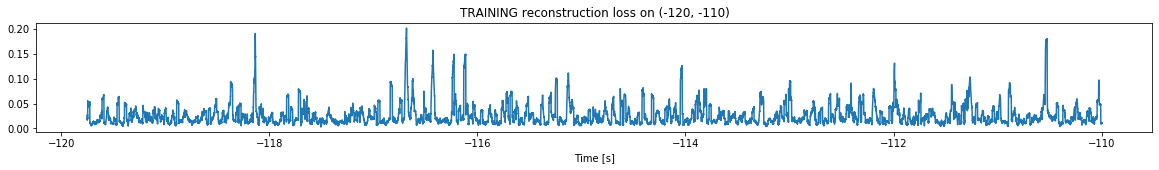

Finished training, median of the log(loss) is:  -1.6964037619841434
Triggering for section:  (-110, 0)
Using this median for triggering: -1.6964037619841434


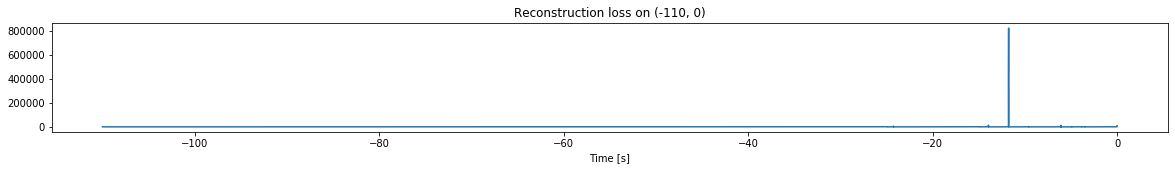

Other trigger time:  [-41.1455    -39.2193    -36.6991    -33.379498  -30.5548    -29.4622
 -24.8527    -24.255999  -23.7023    -22.5403    -21.855     -20.4692
 -19.1218    -17.934     -17.1343    -16.0494    -14.9689    -13.9534
 -11.759     -10.9154     -9.599299   -8.3621     -7.2702     -6.1043
  -4.9003     -3.4945     -2.1564999  -1.3729     -0.4114   ]
Their log loss values are:  [3.51649064 3.85287489 4.47806258 3.93179028 3.37289295 3.56045932
 4.79097724 5.48512473 4.65876856 3.47540691 4.03879813 4.24523364
 4.49928892 3.73093732 4.56142758 4.41409714 4.67039238 5.85629484
 7.61349504 3.58970123 5.18425558 4.27342365 4.61263359 5.81815966
 4.90897416 5.1148658  3.82880184 3.48234612 3.49555444]


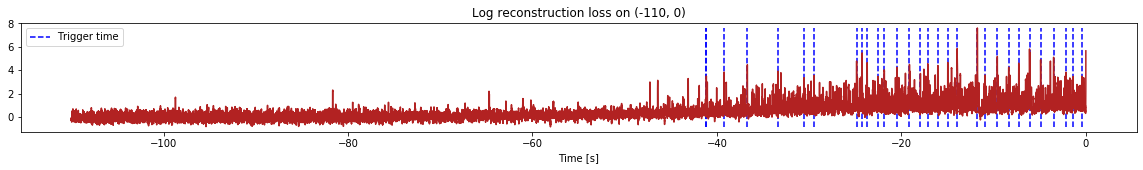

Triggered at:  [-41.1455, -39.2193, -36.6991, -33.379498, -30.5548, -29.4622, -24.8527, -24.255999, -23.7023, -22.5403, -21.855, -20.4692, -19.1218, -17.934, -17.1343, -16.0494, -14.9689, -13.9534, -11.759, -10.9154, -9.599299, -8.3621, -7.2702, -6.1043, -4.9003, -3.4945, -2.1564999, -1.3729, -0.4114]


In [3]:
simulation_static("./data/Ramp21/", 10, (-120,0))

In [4]:
!ls models/

Ramp21-12in.h5	Ramp21-dynamic.h5  Ramp21-static.h5


In [5]:
### compare the two models

In [7]:
dynamic_model = keras.models.load_model("models/Ramp21-dynamic.h5")
static_model = keras.models.load_model("models/Ramp21-static.h5")

In [15]:
dynamic_model.get_weights()

[array([[-0.08132429, -0.09688942, -0.15529613,  0.08066905,  0.21880034,
          0.10666331],
        [-0.44260943, -0.41399106,  0.26921302,  0.30837113, -0.42944792,
         -0.25795457],
        [-0.01095477,  0.82956284, -0.03006309, -0.07853927, -0.1942897 ,
         -0.0401158 ],
        [ 1.0192422 ,  0.37226194, -0.10789001, -0.0084074 ,  0.21779722,
          0.64241815],
        [-0.17592876,  0.27517903, -0.10599333, -0.17066106, -0.598557  ,
          0.03526542],
        [-0.44860098,  0.53429514, -0.26983064,  0.04519737, -0.4670763 ,
         -0.20697837],
        [ 0.3512357 , -0.8389377 , -0.32132795, -0.19247489, -0.08441811,
          0.3496458 ],
        [-0.754061  , -0.68573016,  0.6296512 ,  0.7439374 , -0.12756683,
          0.00325515],
        [-0.5064012 ,  0.8977117 ,  0.4589743 ,  0.37987673, -0.66522104,
          0.49455476],
        [ 0.7953222 , -0.41626027, -0.12575874,  0.00582402,  0.3718738 ,
         -0.20683908],
        [-0.39948943,  0.42871

In [13]:
weight_diff =[]

for i in range(len(dynamic_model.get_weights())):
    dynamic_weight = dynamic_model.get_weights()[i]
    static_weight = static_model.get_weights()[i]
    avg_diff = np.mean(dynamic_weight - static_weight)
    weight_diff.append(avg_diff)

In [14]:
weight_diff

[0.013847136,
 -0.02614899,
 0.08358915,
 -0.011939923,
 0.11190285,
 -0.09005981,
 0.053803857,
 0.047057617]